In [1]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import csv
import datetime as dt
import time
import pickle

from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json
import warnings

from sklearn.model_selection import TimeSeriesSplit

from collections import defaultdict
from collections import namedtuple
import itertools

import space_bandits

# Чтобы сгенерировать UUID
import uuid

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
from multiprocessing import Pool, cpu_count

In [4]:
warnings.filterwarnings('once')

In [5]:
def MAPE_custom(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Read initial data

In [8]:
canc_df = pd.read_csv('data/canc_df.csv')
batch_example = pd.read_csv('data/primer_batch.csv')
posilka_example = pd.read_csv('data/primer_posilki.csv')
feedback_df = pd.read_csv('data/feedback.csv')
promo_df = pd.read_csv('data/promo_df.csv')
sales_plan = pd.read_csv('data/sales_plan.csv')
sample_1000_df = pd.read_csv('data/sample_1000.csv')
transactions_df = pd.read_csv('data/transactions.csv')

transactions_df['dates'] = pd.to_datetime(transactions_df['dates'])

canc_df[['ret_net_price_min']] = canc_df[['ret_net_1_price', 'ret_net_2_price', 'ret_net_3_price']].min(axis=1)
canc_df_gr = canc_df.groupby(['year', 'week_num', 'SKU'], as_index=False).ret_net_price_min.agg(min).drop_duplicates()

# EDA

## competitors data

In [9]:
canc_df.info()
canc_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               10324 non-null  int64  
 1   week_num           10324 non-null  int64  
 2   SKU                10324 non-null  int64  
 3   ret_net_1_price    10324 non-null  float64
 4   ret_net_2_price    10324 non-null  float64
 5   ret_net_3_price    10324 non-null  float64
 6   ret_net_price_min  10324 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 564.7 KB


,year,week_num,SKU,ret_net_1_price,ret_net_2_price,ret_net_3_price,ret_net_price_min
0,2019,1,10121,2945.681342,2965.743797,2917.394830,2917.394830
1,2019,1,10290,949.466060,942.301292,962.799009,942.301292
2,2019,1,10973,3751.515022,3735.814981,3709.586540,3709.586540
3,2019,1,11179,3717.042306,3638.799082,3695.090121,3638.799082
4,2019,1,11680,1378.797669,1325.251312,1363.707489,1325.251312
...,...,...,...,...,...,...,...
10319,2019,52,97659,3409.219608,3394.456244,3434.336572,3394.456244
10320,2019,52,98346,1632.598644,1710.327024,1638.673052,1632.598644
10321,2019,52,98642,1498.441016,1520.235649,1481.583880,1481.583880
10322,2019,52,98774,1649.812737,1638.274072,1725.167364,1638.274072


In [10]:
canc_df.SKU.unique().shape

(271,)

In [11]:
canc_df[['ret_net_price_min']] = canc_df[['ret_net_1_price', 'ret_net_2_price', 'ret_net_3_price']].min(axis=1)
canc_df_gr = canc_df.groupby(['year', 'week_num', 'SKU'], as_index=False).ret_net_price_min.agg(min).drop_duplicates()
canc_df_gr.head()

,year,week_num,SKU,ret_net_price_min
0,2019,1,10121,2917.394830
1,2019,1,10290,942.301292
2,2019,1,10973,3709.586540
3,2019,1,11179,3638.799082
4,2019,1,11680,1325.251312


In [12]:
sum(np.isnan(canc_df_gr.ret_net_price_min.values))

0

## batch example

In [27]:
batch_example.info()
batch_example.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dates    986 non-null    object
 1   SKU      986 non-null    int64 
 2   user_id  986 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 23.2+ KB


,dates,SKU,user_id
0,2019-12-01,31656,22427
1,2019-12-01,29946,47017
2,2019-12-01,24848,30437
3,2019-12-01,59524,41824
4,2019-12-01,98346,26591


In [9]:
print(posilka_example.info())
posilka_example.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dates    986 non-null    object
 1   SKU      986 non-null    int64 
 2   user_id  986 non-null    int64 
 3   price    986 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 30.9+ KB
None


,dates,SKU,user_id,price
0,2019-12-01,31656,22427,0
1,2019-12-01,29946,47017,1
2,2019-12-01,24848,30437,2
3,2019-12-01,59524,41824,3
4,2019-12-01,98346,26591,4


In [10]:
feedback_df.head()

,dates,SKU,user_id,price,bought
0,2019-12-01,31656,22427,0,1
1,2019-12-01,29946,47017,1,0
2,2019-12-01,24848,30437,2,0
3,2019-12-01,59524,41824,3,0
4,2019-12-01,98346,26591,4,1


## promo

In [8]:
promo_df.info()
promo_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SKU       2342 non-null   int64  
 1   week_num  2342 non-null   int64  
 2   year      2342 non-null   int64  
 3   discount  2342 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 73.3 KB


,SKU,week_num,year,discount
0,74430,1,2018,0.15
1,69978,1,2018,0.05
2,81955,1,2018,0.15
3,78953,1,2018,0.10
4,43034,1,2018,0.05
...,...,...,...,...
2337,35645,52,2019,0.15
2338,81314,52,2019,0.05
2339,75661,52,2019,0.05
2340,38664,52,2019,0.05


In [29]:
promo_df[['week_num', 'year']].drop_duplicates()

,week_num,year
0,1,2018
6,2,2018
7,3,2018
9,4,2018
11,5,2018
...,...,...
2144,48,2019
2186,49,2019
2225,50,2019
2262,51,2019


## sales

In [30]:
sales_plan.info()
sales_plan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12212 entries, 0 to 12211
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SKU         12212 non-null  int64  
 1   year        12212 non-null  int64  
 2   month       12212 non-null  int64  
 3   plan        12212 non-null  float64
 4   back_bonus  12212 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 477.2 KB


,SKU,year,month,plan,back_bonus
0,10290,2018,2,20.0,120000
1,10290,2018,3,60.0,140000
2,10290,2018,4,70.0,140000
3,10290,2018,5,60.0,140000
4,10290,2018,6,60.0,40000


In [49]:
sales_plan.back_bonus.describe()

count     12212.000000
mean     119977.071733
std       51569.736141
min       40000.000000
25%       80000.000000
50%      120000.000000
75%      160000.000000
max      200000.000000
Name: back_bonus, dtype: float64

In [50]:
sales_plan.back_bonus.sum()

1465160000

In [51]:
sales_plan.plan.describe()

count    12212.000000
mean       117.880773
std         55.734576
min          0.000000
25%         80.000000
50%        120.000000
75%        160.000000
max        260.000000
Name: plan, dtype: float64

In [52]:
sales_plan.plan.sum()

1439560.0

## SKU

In [31]:
sample_1000_df.info()
sample_1000_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sku_id           1000 non-null   int64 
 1   fincode          1000 non-null   object
 2   ui1_code         1000 non-null   object
 3   ui2_code         1000 non-null   object
 4   ui3_code         1000 non-null   object
 5   vendor           1000 non-null   object
 6   brand_code       1000 non-null   object
 7   creation_date    1000 non-null   object
 8   expiration_date  1000 non-null   object
dtypes: int64(1), object(8)
memory usage: 70.4+ KB


,sku_id,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,16663,Z8,Z81,Z8100,Z810000,FI3ASO,THSTSG81,2018-06-26,2019-04-21 00:00:00
1,91775,Q5,Q51,Q5100,Q510008,4O4WSH,WKXRWTP7,2019-07-07,2200-01-01 00:00:00
2,24641,ZR,ZR1,ZR100,ZR10000,71SM2O,J8XKU94W,2019-05-22,2200-01-01 00:00:00
3,84184,UA,UA1,UA102,UA10205,FI3ASO,5IEJMU4O,2018-04-19,2019-06-19 00:00:00
4,21070,XG,XG1,XG100,XG10000,4O4WSH,4WL34OA2,2019-06-27,2200-01-01 00:00:00


In [57]:
sample_1000_df[['expiration_date']].sort_values(by='expiration_date').head(25)

,expiration_date
759,2018-03-18 00:00:00
630,2018-03-25 00:00:00
232,2018-03-31 00:00:00
77,2018-04-02 00:00:00
25,2018-04-07 00:00:00
435,2018-04-11 00:00:00
495,2018-04-22 00:00:00
644,2018-04-23 00:00:00
164,2018-05-09 00:00:00
484,2018-06-05 00:00:00


## transactions

In [43]:
transactions_df.info()
transactions_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334260 entries, 0 to 1334259
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   dates   1334260 non-null  object 
 1   SKU     1334260 non-null  int64  
 2   user    1334260 non-null  int64  
 3   price   1334260 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 40.7+ MB


,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [44]:
transactions_df.SKU.unique().shape

(1000,)

In [45]:
transactions_df.user.unique().shape

(11062,)

In [46]:
print(transactions_df['dates'].describe())
print(transactions_df.dates.min())
print(transactions_df.dates.max())

count        1334260
unique           699
top       2019-09-01
freq            3433
Name: dates, dtype: object
2018-01-01
2019-11-30


In [47]:
transactions_df.price.describe()

count    1.334260e+06
mean     2.315643e+03
std      1.245505e+03
min      1.010000e+02
25%      1.270000e+03
50%      2.193000e+03
75%      3.478000e+03
max      4.649000e+03
Name: price, dtype: float64

## prices

In [11]:
sku_list = transactions_df.SKU.unique()
transactions_df.head()

,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [12]:
trans_gr_df = transactions_df.groupby(['dates', 'SKU', 'price'], as_index=False)\
.agg(price_mean = pd.NamedAgg('price', np.mean))
trans_gr_df.info()
trans_gr_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318956 entries, 0 to 318955
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   dates       318956 non-null  datetime64[ns]
 1   SKU         318956 non-null  int64         
 2   price       318956 non-null  float64       
 3   price_mean  318956 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 12.2 MB


,dates,SKU,price,price_mean
0,2018-01-01,67369,3607.0,3607.0
1,2018-01-02,67369,3607.0,3607.0
2,2018-01-03,26629,1126.0,1126.0
3,2018-01-03,41262,3473.0,3473.0
4,2018-01-03,67369,3607.0,3607.0


In [13]:
## plot some prices
sku_gr_1 = np.append(sku_list[:20], 39544) 

trace_list = []

for sku_i in sku_gr_1:
    trace = go.Scatter(
        x=trans_gr_df.loc[trans_gr_df.SKU == sku_i, 'dates'],
        y=trans_gr_df.loc[trans_gr_df.SKU == sku_i, 'price_mean'],
        name=sku_i.astype(str)
    )
    trace_list.append(trace)

In [14]:
plt.figure(figsize=(12, 8))
layout = {'title': 'SKU prices'}
fig = go.Figure(data=trace_list, layout=layout)
iplot(fig, show_link=False)

<Figure size 864x576 with 0 Axes>

# RFM users

In [35]:
transactions_df.info()
transactions_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334260 entries, 0 to 1334259
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   dates   1334260 non-null  datetime64[ns]
 1   SKU     1334260 non-null  int64         
 2   user    1334260 non-null  int64         
 3   price   1334260 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 40.7 MB


,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [13]:
df_to_rfm = transactions_df.groupby(['user', 'dates', 'SKU', 'price'], as_index=False)\
.agg(price_mean = pd.NamedAgg('price', np.mean),
     price_sum = pd.NamedAgg('price', np.sum),
     n_items = pd.NamedAgg('price', np.count_nonzero)
    )
df_to_rfm['dates'] = pd.to_datetime(df_to_rfm['dates'])

df_to_rfm.info()
df_to_rfm.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333733 entries, 0 to 1333732
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user        1333733 non-null  int64         
 1   dates       1333733 non-null  datetime64[ns]
 2   SKU         1333733 non-null  int64         
 3   price       1333733 non-null  float64       
 4   price_mean  1333733 non-null  float64       
 5   price_sum   1333733 non-null  float64       
 6   n_items     1333733 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 81.4 MB


,user,dates,SKU,price,price_mean,price_sum,n_items
0,10002,2018-03-22,11666,691.0,691.0,691.0,1.0
1,10002,2018-04-19,81822,2014.0,2014.0,2014.0,1.0
2,10002,2018-06-15,72165,301.0,301.0,301.0,1.0
3,10002,2018-06-25,29946,1548.0,1548.0,1548.0,1.0
4,10002,2018-07-08,70358,3494.0,3494.0,3494.0,1.0


In [14]:
sum((df_to_rfm.price_mean != df_to_rfm.price_sum))

527

In [15]:
df_to_rfm_gr = df_to_rfm.groupby(['user', 'dates'], as_index=False)\
.agg(price_per_visit = pd.NamedAgg('price_sum', np.sum),
     price_avg_per_visit = pd.NamedAgg('price_sum', np.mean),
     n_items_per_visit = pd.NamedAgg('n_items', np.sum)
    )
df_to_rfm_gr['dates'] = pd.to_datetime(df_to_rfm_gr['dates'])

df_to_rfm_gr.info()
df_to_rfm_gr.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086271 entries, 0 to 1086270
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   user                 1086271 non-null  int64         
 1   dates                1086271 non-null  datetime64[ns]
 2   price_per_visit      1086271 non-null  float64       
 3   price_avg_per_visit  1086271 non-null  float64       
 4   n_items_per_visit    1086271 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 49.7 MB


,user,dates,price_per_visit,price_avg_per_visit,n_items_per_visit
0,10002,2018-03-22,691.0,691.0,1.0
1,10002,2018-04-19,2014.0,2014.0,1.0
2,10002,2018-06-15,301.0,301.0,1.0
3,10002,2018-06-25,1548.0,1548.0,1.0
4,10002,2018-07-08,3494.0,3494.0,1.0


In [16]:
df_to_rfm_gr.loc[df_to_rfm_gr.n_items_per_visit > 1, ]

,user,dates,price_per_visit,price_avg_per_visit,n_items_per_visit
26,10002,2019-06-23,3683.0,1841.5,2.0
44,10003,2018-04-03,4347.0,2173.5,2.0
53,10003,2018-05-16,3866.0,1933.0,2.0
77,10003,2018-08-17,3881.0,1940.5,2.0
80,10003,2018-08-27,7414.0,3707.0,2.0
...,...,...,...,...,...
1086248,49999,2019-08-22,4628.0,2314.0,2.0
1086251,49999,2019-08-30,5430.0,2715.0,2.0
1086259,49999,2019-10-26,3327.0,1663.5,2.0
1086262,49999,2019-11-03,2805.0,1402.5,2.0


In [17]:
PRESENT = pd.to_datetime('2020-01-31') # самая новая дата
PRESENT

Timestamp('2020-01-31 00:00:00')

In [18]:
rfm = df_to_rfm_gr.groupby('user', as_index=False).agg(
    
    # recency
    dates_first = pd.NamedAgg('dates', lambda dates: (PRESENT - dates.min()).days), # дней с первой покупки
    dates_last = pd.NamedAgg('dates', lambda dates: (PRESENT - dates.max()).days), # дней с последней покупки
    
    # frequency
    n_visits = pd.NamedAgg('n_items_per_visit', np.count_nonzero), # число визитов
    n_items_avg = pd.NamedAgg('n_items_per_visit', np.mean), # число покупок в чеке среднее
    
    # monetary
    bill_avg = pd.NamedAgg('price_per_visit', np.mean), # средний чек
    price_per_item_avg = pd.NamedAgg('price_avg_per_visit', np.mean), # средняя цена товара в чеке
    total_money_spent = pd.NamedAgg('price_per_visit', np.sum), # сумма трат тотал
    
    )

rfm['dates_range'] = rfm.dates_first - rfm.dates_last # период покупок
rfm['visits_freq'] = rfm.n_visits / rfm.dates_range # частота покупок

# rfm.rename(columns={'dates': 'days_after_last_purch', 'price_per_visit': 'money_per_visit'}, inplace=True)
rfm.info()
rfm.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11062 entries, 0 to 11061
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user                11062 non-null  int64  
 1   dates_first         11062 non-null  int64  
 2   dates_last          11062 non-null  int64  
 3   n_visits            11062 non-null  float64
 4   n_items_avg         11062 non-null  float64
 5   bill_avg            11062 non-null  float64
 6   price_per_item_avg  11062 non-null  float64
 7   total_money_spent   11062 non-null  float64
 8   dates_range         11062 non-null  int64  
 9   visits_freq         11062 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 950.6 KB


,user,dates_first,dates_last,n_visits,n_items_avg,bill_avg,price_per_item_avg,total_money_spent,dates_range,visits_freq
0,10002,680,66,40.0,1.025000,2603.900000,2557.862500,104156.0,614,0.065147
1,10003,715,62,305.0,1.472131,3515.354098,2407.502404,1072183.0,653,0.467075
2,10006,728,79,36.0,1.027778,2622.444444,2568.625000,94408.0,649,0.055470
3,10008,751,70,44.0,1.022727,2512.931818,2445.568182,110569.0,681,0.064611
4,10009,700,63,117.0,1.128205,2583.025641,2327.648148,302214.0,637,0.183673


In [19]:
# rfm = df_to_rfm_gr.groupby('user', as_index=False).agg({
#         'dates': lambda dates: (PRESENT - dates.max()).days, # дней с последней покупки
#         'n_items_per_visit': 'count',                                    # число заказов
#         'price_per_visit': 'sum'                                      # суммарные траты
#     })
# rfm.rename(columns={'dates': 'days_after_last_purch', 'price_per_visit': 'money_per_visit'}, inplace=True)
# rfm.info()
# rfm.head()

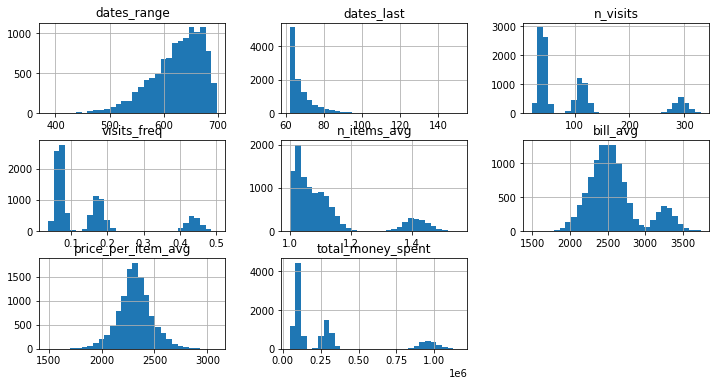

In [20]:
rfm[['dates_range', 'dates_last', 'n_visits', 'visits_freq', 'n_items_avg',\
     'bill_avg', 'price_per_item_avg', 'total_money_spent']].hist(figsize=(12,6), bins=30);

## RFM clusters

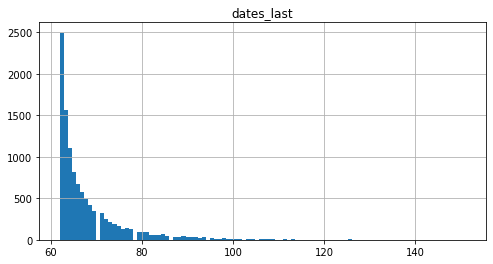

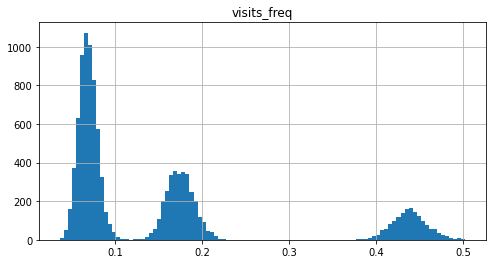

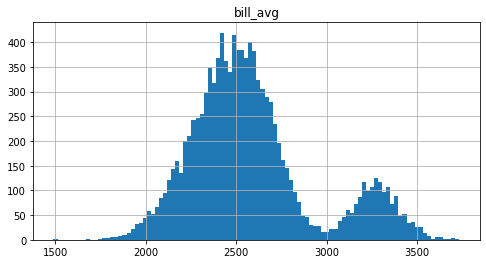

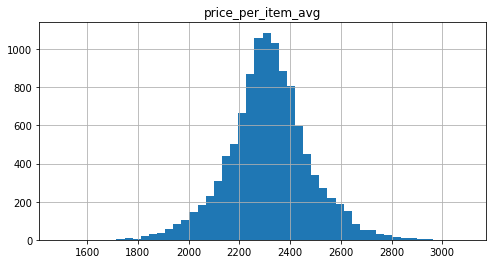

In [21]:
rfm[['dates_last']].hist(figsize=(8,4), bins=100); # recency
ax_recency = plt.gca()
rfm[['visits_freq']].hist(figsize=(8,4), bins=100); # frequency
ax_freq = plt.gca()
rfm[['bill_avg']].hist(figsize=(8,4), bins=100); # monetary_bill
ax_monet_bill = plt.gca()
rfm[['price_per_item_avg']].hist(figsize=(8,4), bins=50); # monetary_sku
ax_monet_sku = plt.gca()

In [22]:
## recency
patches_recency = ax_recency.patches

heights = [patch.get_height() for patch in patches_recency]
widths = [patch.get_width() for patch in patches_recency]
x_labels = [patch.get_xy()[0] for patch in patches_recency]

df_hist_recency = pd.DataFrame({'x_labels': x_labels, 'heights': heights, 'widths': widths})
df_hist_recency.head(30)

,x_labels,heights,widths
0,62.00,2493.0,0.89
1,62.89,1562.0,0.89
2,63.78,1103.0,0.89
3,64.67,817.0,0.89
4,65.56,673.0,0.89
5,66.45,578.0,0.89
6,67.34,486.0,0.89
7,68.23,417.0,0.89
8,69.12,343.0,0.89
9,70.01,0.0,0.89


In [23]:
## frequency
patches_freq = ax_freq.patches

heights = [patch.get_height() for patch in patches_freq]
widths = [patch.get_width() for patch in patches_freq]
x_labels = [patch.get_xy()[0] for patch in patches_freq]

df_hist_freq = pd.DataFrame({'x_labels': x_labels, 'heights': heights, 'widths': widths})
df_hist_freq.head(30)

,x_labels,heights,widths
0,0.035874,7.0,0.004665
1,0.040540,50.0,0.004665
2,0.045205,160.0,0.004665
3,0.049871,372.0,0.004665
4,0.054536,631.0,0.004665
5,0.059201,959.0,0.004665
6,0.063867,1073.0,0.004665
7,0.068532,1010.0,0.004665
8,0.073198,830.0,0.004665
9,0.077863,572.0,0.004665


In [24]:
## monetary_1
patches_monet_1 = ax_monet_bill.patches

heights = [patch.get_height() for patch in patches_monet_1]
widths = [patch.get_width() for patch in patches_monet_1]
x_labels = [patch.get_xy()[0] for patch in patches_monet_1]

df_hist_monet_1 = pd.DataFrame({'x_labels': x_labels, 'heights': heights, 'widths': widths})
df_hist_monet_1.iloc[60:80, ]

,x_labels,heights,widths
60,2836.842349,77.0,22.426539
61,2859.268888,48.0,22.426539
62,2881.695427,46.0,22.426539
63,2904.121966,30.0,22.426539
64,2926.548505,28.0,22.426539
65,2948.975044,27.0,22.426539
66,2971.401584,16.0,22.426539
67,2993.828123,15.0,22.426539
68,3016.254662,22.0,22.426539
69,3038.681201,22.0,22.426539


In [25]:
## monetary_1
np.quantile(rfm.price_per_item_avg, [0.1, 0.9])

array([2119.86723404, 2515.60888067])

## define RFM rules

In [26]:
# recency
bounds_rec = [70, 78]

# frequency
bounds_freq = [0.115, 0.3]

# monetary_bill
bounds_mnt_1 = [3000]

# monetary_sku
bounds_mnt_2 = [2120, 2515]

In [27]:
# test
np.digitize([0, 2500, 250000, -1], bounds_mnt_2)

array([0, 1, 2, 0])

# Test to predict price0 (before bandits)

## Prophet

In [28]:
## group known SKU prices day dates
trans_gr_df = transactions_df.groupby(['dates', 'SKU', 'price'], as_index=False)\
.agg(price_mean = pd.NamedAgg('price', np.mean))
trans_gr_df['dates'] = pd.to_datetime(trans_gr_df['dates'])

trans_gr_df.info()
trans_gr_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318956 entries, 0 to 318955
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   dates       318956 non-null  datetime64[ns]
 1   SKU         318956 non-null  int64         
 2   price       318956 non-null  float64       
 3   price_mean  318956 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 12.2 MB


,dates,SKU,price,price_mean
0,2018-01-01,67369,3607.0,3607.0
1,2018-01-02,67369,3607.0,3607.0
2,2018-01-03,26629,1126.0,1126.0
3,2018-01-03,41262,3473.0,3473.0
4,2018-01-03,67369,3607.0,3607.0


In [29]:
## attach promo df and calc cleaned mean price

In [30]:
trans_gr_df['week_num'] = trans_gr_df['dates'].dt.isocalendar().week
trans_gr_df['year'] = trans_gr_df['dates'].dt.isocalendar().year
trans_gr_df['month'] = trans_gr_df['dates'].dt.month

In [31]:
trans_gr_df2 = trans_gr_df.merge(promo_df, how='left',\
                                on=['SKU', 'year', 'week_num'])
trans_gr_df2.loc[np.isnan(trans_gr_df2.discount), 'discount'] = 0
trans_gr_df2['price_mean_cl'] = trans_gr_df2['price_mean'] / \
    (1 - trans_gr_df2['discount'])
trans_gr_df2.head()

,dates,SKU,price,price_mean,week_num,year,month,discount,price_mean_cl
0,2018-01-01,67369,3607.0,3607.0,1,2018,1,0.0,3607.0
1,2018-01-02,67369,3607.0,3607.0,1,2018,1,0.0,3607.0
2,2018-01-03,26629,1126.0,1126.0,1,2018,1,0.0,1126.0
3,2018-01-03,41262,3473.0,3473.0,1,2018,1,0.0,3473.0
4,2018-01-03,67369,3607.0,3607.0,1,2018,1,0.0,3607.0


In [32]:
## calendar effects periods

# holydays
holidays_weeks = pd.DataFrame({
  'holiday': 'holidays_weeks',
  'ds': pd.date_range('2018-08-27', '2018-09-02', freq='D')\
    .append(pd.date_range('2019-08-26', '2019-09-01', freq='D'))\
    .append(pd.date_range('2018-02-18', '2018-02-24', freq='D'))\
    .append(pd.date_range('2019-02-18', '2019-02-24', freq='D'))\
    .append(pd.date_range('2018-03-04', '2018-03-10', freq='D'))\
    .append(pd.date_range('2019-03-04', '2019-03-10', freq='D'))\
    .append(pd.date_range('2018-04-29', '2018-05-12', freq='D'))\
    .append(pd.date_range('2019-04-29', '2019-05-12', freq='D'))\
    .append(pd.date_range('2018-12-10', '2019-01-13', freq='D'))\
    .append(pd.date_range('2019-12-09', '2020-01-13', freq='D')),
  'lower_window': 0,
  'upper_window': 0,
})

# SKU == 70036
summer_weeks = pd.DataFrame({
  'holiday': 'summer_weeks',
  'ds': pd.date_range('2018-05-06', '2018-09-08', freq='D')\
    .append(pd.date_range('2019-05-06', '2019-09-08', freq='D')),
  'lower_window': 0,
  'upper_window': 0,
})

# preNY_weeks_1 = pd.DataFrame({
#   'holiday': 'preNY_weeks_1',
#   'ds': pd.date_range('2018-12-10', '2019-01-13', freq='D')\
#     .append(pd.date_range('2019-12-10', '2020-01-13', freq='D')),
#   'lower_window': 0,
#   'upper_window': 0,
# })

# SKU == 35200
preNY_weeks_2 = pd.DataFrame({
  'holiday': 'preNY_weeks_2',
  'ds': pd.date_range('2018-12-10', '2019-01-13', freq='D')\
    .append(pd.date_range('2019-12-10', '2020-01-13', freq='D')),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_cl1 = holidays_weeks
holidays_cl2 = summer_weeks
holidays_cl3 = preNY_weeks_2
holidays_ttl = holidays_cl1.append(holidays_cl2).append(holidays_cl3)

### test with timeseries CV

In [17]:
sku_list_ttl = transactions_df.SKU.unique()
sku_list = sku_list_ttl[:3]

In [18]:
%%time
column_names = ['SKU', 'dates', 'price_mean_hat']
predict_prophet_df = pd.DataFrame(columns = column_names)
conf_int = 0.95
mape_list = []
ii = 0
prophet_dict_tst = {}

for sku_i in sku_list:
    
    ii += 1
    if ii % 10 == 0:
        print(ii)
    
    # subset SKU data & init tsCV
    trans_gr_df2_i = trans_gr_df2.loc[trans_gr_df2.SKU == sku_i, ]
    
    tscv = TimeSeriesSplit(\
            n_splits=4,\
            max_train_size=(int(trans_gr_df2_i.shape[0] // 1.25)))
    
    mape_list.append(('SKU ' + str(sku_i)))
    
    for train_index, test_index in tscv.split(trans_gr_df2_i):
        
        # split train test
        trans_gr_train = trans_gr_df2_i.iloc[train_index, :]
        trans_gr_test = trans_gr_df2_i.iloc[test_index, :]
        
        # fit prophet
        prophet = Prophet(interval_width = conf_int, holidays=holidays_ttl)
        prophet.fit(trans_gr_train[['dates', 'price_mean_cl']]\
                    .rename(columns={'dates':'ds','price_mean_cl':'y'}))
        
        # reduce model size
        prophet.history = 'aa'
        prophet.history_dates = 'aa'
        prophet.stan_backend = None
        
        prophet_dict_tst[sku_i] = prophet
        
        # predict
        pred_df1_i = prophet_dict_tst[sku_i].predict(trans_gr_test[['dates']]\
                                     .rename(columns={'dates':'ds'}))
        pred_df2_i = pd.DataFrame({'SKU': sku_i, 'dates': pred_df1_i.ds,\
                                  'price_mean_cl_hat': pred_df1_i.yhat})
                           
        # join discount & calc price with promo
        pred_df2_i['week_num'] = pred_df2_i['dates'].dt.isocalendar().week
        pred_df2_i['year'] = pred_df2_i['dates'].dt.isocalendar().year
        pred_df3_i = pred_df2_i.merge(promo_df, how='left',\
                         on=['SKU', 'year', 'week_num'])
        
        pred_df3_i.loc[np.isnan(pred_df3_i.discount), 'discount'] = 0
        pred_df3_i['price_mean_hat'] = pred_df3_i['price_mean_cl_hat'] * \
            (1 - pred_df3_i['discount'])
            
#         pred_df2_i['price_mean_hat'] = pred_df2_i['price_mean_cl_hat'] * \
#             (1 - pred_df2_i['discount'])
        
        ## add minimal comp price & 
        ## test to set price_mean_hat to min(comp_price) * ~0.99 
        
        # attach to total df
        predict_prophet_df = predict_prophet_df.append(pred_df3_i)
        
        # save mape
        mape_j = MAPE_custom(\
            trans_gr_df2_i.price_mean.values[test_index],\
            pred_df3_i.price_mean_hat.values)

        mape_list.append(mape_j)
    
    mape_list.append(np.mean(mape_list[-4:]))


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyboardInterrupt: 

In [92]:
mape_list

['SKU 16019',
 1.8186348447788911,
 0.6255746315696763,
 1.517760676939468,
 0.6131944045855945,
 1.1437911394684075,
 'SKU 39544',
 12.363427206504396,
 4.605608752290389,
 0.7076438869807716,
 5.483416819966052,
 5.790024166435402,
 'SKU 85915',
 2.2429747035497343,
 1.4003664509927702,
 1.1404857763191274,
 0.9557088340350289,
 1.4348839412241652,
 'SKU 30482',
 1.5579198928248181,
 1.6296041785934912,
 1.0516220117694735,
 0.766525497497318,
 1.251417895171275,
 'SKU 76988',
 3.479717051886351,
 2.6549391055501794,
 1.060584614735689,
 1.375595228906292,
 2.142709000269628,
 'SKU 58998',
 5.170378963640883,
 5.268244639660884,
 1.9946353484722221,
 0.761842893283963,
 3.2987754612644884,
 'SKU 27600',
 1.8387906068434923,
 4.4600085318730756,
 2.261231184814095,
 2.1219548978712,
 2.670496305350466,
 'SKU 53038',
 6.039767043161709,
 1.3098814128079221,
 0.9690445983814343,
 0.7641343388768657,
 2.270706848306983,
 'SKU 36487',
 3.473152815336258,
 0.5360969742870108,
 1.0356473324

In [93]:
print(np.mean(mape_list[5::6]))
np.quantile(mape_list[5::6], 0.9)

2.3664063121250716


3.5479003317815834

### fit all SKU models

In [33]:
sku_list_ttl = transactions_df.SKU.unique()
sku_list = sku_list_ttl

In [34]:
%%time
## to fit & write 500 models 3:45 min
## to fit 1000 models 7:30 min
## to fit with uncertanty_samples=0 1000 models 7:30 min

column_names = ['SKU', 'dates', 'price_mean_hat']
predict_prophet_df = pd.DataFrame(columns = column_names)
conf_int = 0.00

prophet_dict_1 = {}

ii = 0
for sku_i in sku_list:
    
    ii += 1
    if ii % 10 == 0:
        print(ii)
    
    # subset SKU data & init tsCV
    trans_gr_df2_i = trans_gr_df2.loc[trans_gr_df2.SKU == sku_i, ]
    
    trans_gr_train = trans_gr_df2_i

    # fit prophet
    prophet = Prophet(interval_width = conf_int, holidays=holidays_ttl,\
                      yearly_seasonality=False, daily_seasonality=False,\
                      uncertainty_samples = 0)
    prophet.fit(trans_gr_train[['dates', 'price_mean_cl']]\
                .rename(columns={'dates':'ds','price_mean_cl':'y'}))
    
    # test to fix only stan_backend & to write models
    prophet.history = 'aa'
    prophet.history_dates = 'aa'
    prophet.stan_backend = None
    
    prophet_dict_1[sku_i] = prophet
    
#     with open('prophet_models_1/prophet_{}.pkl'.format(sku_i), 'w') as fout:
#         json.dump(model_to_json(prophet), fout)  # Save model

#     # attach to total df
#     predict_prophet_df = predict_prophet_df.append(pred_df2_i)


10
20
30
40
50
60


SystemError: <class 'stanfit4anon_model_dfdaf2b8ece8a02eb11f050ec701c0ec_4494739491550052512.PyStanHolder'> returned a result with an error set

In [35]:
# # Save models dict
# save_obj(prophet_dict_1, 'prophet_dict_1')

In [49]:
# Load models dict
prophet_dict_1 = load_obj('prophet_dict_1')

In [50]:
# %%time
# ## to read 500 prophet models 0:43 min

# for sku_i in sku_list:
#     with open('prophet_models_1/prophet_{}.pkl'.format(sku_i), 'r') as fin:
#         model_prophet = model_from_json(json.load(fin))  # Load model


# Bandits

## create Bandits context dict

### RFM metrics

In [51]:
# recency
print('bounds_rec', bounds_rec)

# frequency
print('bounds_freq', bounds_freq)

# monetary_bill
print('bounds_mnt_1', bounds_mnt_1)

# monetary_sku
print('bounds_mnt_2', bounds_mnt_2)

print('min(rfm.dates_range)', min(rfm.dates_range))

bounds_rec [70, 78]
bounds_freq [0.115, 0.3]
bounds_mnt_1 [3000]
bounds_mnt_2 [2120, 2515]
min(rfm.dates_range) 386


In [52]:
# test
np.digitize([0, 2500, 250000, -1], bounds_mnt_1)

array([0, 0, 1, 0])

In [53]:
## create users RFM dict
user_context = namedtuple('user_context', ['rec', 'freq', 'monet1', 'monet2', 'dates_range'])
bandits_context_dict = defaultdict(lambda: user_context(rec=0, freq=2, monet1=1, monet2=2, dates_range=385))

In [54]:
rfm.head()

,user,dates_first,dates_last,n_visits,n_items_avg,bill_avg,price_per_item_avg,total_money_spent,dates_range,visits_freq
0,10002,680,66,40.0,1.025000,2603.900000,2557.862500,104156.0,614,0.065147
1,10003,715,62,305.0,1.472131,3515.354098,2407.502404,1072183.0,653,0.467075
2,10006,728,79,36.0,1.027778,2622.444444,2568.625000,94408.0,649,0.055470
3,10008,751,70,44.0,1.022727,2512.931818,2445.568182,110569.0,681,0.064611
4,10009,700,63,117.0,1.128205,2583.025641,2327.648148,302214.0,637,0.183673


In [55]:
for idx, rfm_i in rfm.iterrows():
    
    ## get user context
    rec_i = np.digitize(rfm_i['dates_last'], bounds_rec)  # recency
    freq_i = np.digitize(rfm_i['visits_freq'], bounds_freq)  # frequency
    mnt_1_i = np.digitize(rfm_i['bill_avg'], bounds_mnt_1) # monetary_bill
    mnt_2_i = np.digitize(rfm_i['price_per_item_avg'], bounds_mnt_2) # monetary_sku
    dates_range_i = rfm_i['dates_range']
    
    ## add user context to dict
    bandits_context_dict[rfm_i['user']] = user_context(rec_i, freq_i, mnt_1_i, mnt_2_i, dates_range_i)

In [56]:
bandits_context_dict[10003]

user_context(rec=0, freq=2, monet1=1, monet2=1, dates_range=653.0)

### previous purchase dict

In [57]:
prev_purch_dict = defaultdict(lambda: -1)

In [58]:
transactions_df.head()

,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [59]:
last_purch_prices_df = transactions_df.loc[transactions_df.reset_index()\
    .groupby(['user'])['dates'].idxmax()].sort_values(by = 'dates').reset_index()
last_purch_prices_df.rename(columns={'user': 'user_id'}, inplace=True)
last_purch_prices_df.drop(['index', 'dates', 'SKU'], 1, inplace=True)
last_purch_prices_df.info()
last_purch_prices_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11062 entries, 0 to 11061
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  11062 non-null  int64  
 1   price    11062 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 173.0 KB


,user_id,price
0,14634,2487.0
1,34909,2085.0
2,47175,3041.0
3,18059,905.0
4,10819,3596.0


In [60]:
for idx, user_id_i in last_purch_prices_df.iterrows():
    prev_purch_dict[user_id_i['user_id']] = user_id_i['price']

In [61]:
prev_purch_dict[14634]

2487.0

In [62]:
prev_purch_dict[-3242322]

-1

## Test to predict price1 (with correction on competitors price)

## Test to predict price1 (with bandits)

# Pipelines with server requests

## examples requests to server

In [98]:
UUID = uuid.uuid4().hex
UUID

'e154599ae2ce4ab5a1fa4220a68d58da'

In [99]:
URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{}/begin'\
.format(UUID)
req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
# Для получения информации о том как отработал запрос, можно посмотреть ответ
print(req.json())

In [76]:
URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))

# Чтобы перевести полученный ответ в pd.DataFrame
batch_df = pd.read_json(response.json())

In [77]:
batch_df.info()
batch_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dates    6000 non-null   object
 1   SKU      6000 non-null   int64 
 2   user_id  6000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 140.8+ KB


,dates,SKU,user_id
0,2019-12-01,82488,42382
1,2019-12-01,55685,39764
2,2019-12-01,41262,13103
3,2019-12-01,87112,19268
4,2019-12-01,77374,34607


In [79]:
batch_df['dates'] = pd.to_datetime(batch_df['dates'])
batch_df['dates'].describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                    6000
unique                      6
top       2019-12-01 00:00:00
freq                     1053
first     2019-12-01 00:00:00
last      2019-12-06 00:00:00
Name: dates, dtype: object

In [ ]:
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))

# Чтобы перевести полученный ответ в pd.DataFrame
df = pd.read_json(response.json())

## prophet only prediction without refits

In [36]:
# # used to predict 
# sku_list_ttl
# prophet_dict_1

In [19]:
UUID = uuid.uuid4().hex
UUID
# 'ed75d9cfb6c344b8b9d0afcc61a02c0b'
# '8c43230d0d194a94a6cf7813caa413a1'
# 'c7fdb8d9c61b48e1af0fdedef7a1cf5d'
# '1a0be77fd9094833802ade4f45240530'
# 'f588c1cfbedd4f9d9d06473281ffcea8'
# '2f401139ba53419487c4378dd15889b1'
# '465617c8b69a4c4fadb4c044643a1de5'
# 'edbc9bd7710543a9ae8621ad58084968'
# '3c4564a3b84f4df18eb92e8282432c1a'
# '91dd0e2ce97742e6b95b6e8d97df7d35'
# '3ca9af9e47e44c34bd3013c6af11a79f'
# 'ed57222532144c05b25e8d353d53dafb'
# 'b770298e4b104e43bb39e4d67306d4a4'
# '53f36623e2cb42649fa949c07f460fa7' # 32774040 - 20 points
# 'dbd0ad4f1a8d4ed6b1081ee232f544a7'

'dbd0ad4f1a8d4ed6b1081ee232f544a7'

In [20]:
URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
# Для получения информации о том как отработал запрос, можно посмотреть ответ
print(req.json())

{'status': 'ok'}


In [21]:
sent_batches_list = [] 
get_batches2_list = []

In [22]:
%%time
# 8:38 - 8:41, 4 mins per iter
# best attemption 31kk score

for get_batch_i in range(5):
    ## get new batch
    URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
    response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))
    
    try:
        print(response.json()['status'])
    except:
        pass
    
    # Чтобы перевести полученный ответ в pd.DataFrame
    try:
        batch_df = pd.read_json(response.json())
    except:
        pass
    
    batch_df['dates'] = pd.to_datetime(batch_df['dates'])
    # batch_df['price'] = 0

    ## predict prices
    column_names = ['dates', 'SKU', 'price']
    predict_prophet_df = pd.DataFrame(columns = column_names)
    conf_int = 0.00
    ii = 0
    sku_list = batch_df.SKU.unique()

    print(batch_df.head())
    
    for sku_i in sku_list:

        ii += 1
        if ii % 100 == 0:
            print(ii)

        # subset SKU data & init tsCV
        trans_gr_test = batch_df.loc[batch_df.SKU == sku_i, ]
        trans_gr_test = trans_gr_test[['dates', 'SKU']].drop_duplicates()

        # predict
        pred_df1_i = prophet_dict_1[sku_i].predict(trans_gr_test[['dates']]\
                             .rename(columns={'dates':'ds'}))
        pred_df2_i = pd.DataFrame({'SKU': sku_i, 'dates': pred_df1_i.ds,\
                                  'price_mean_cl_hat': pred_df1_i.yhat})
#         print(pred_df1_i.yhat.head())
        
        # join discount & calc price with promo
        pred_df2_i['week_num'] = pred_df2_i['dates'].dt.isocalendar().week
        pred_df2_i['year'] = pred_df2_i['dates'].dt.isocalendar().year
        pred_df3_i = pred_df2_i.merge(promo_df, how='left',\
                         on=['SKU', 'year', 'week_num'])

        pred_df3_i.loc[np.isnan(pred_df3_i.discount), 'discount'] = 0
        pred_df3_i['price'] = pred_df3_i['price_mean_cl_hat'] * \
            (1 - pred_df3_i['discount']) # \
#             * 0.98 # try to simple decrease price on 5%
        
        # set small off to cheap SKU and bigger off to expiensive SKU
        pred_df4_i = pred_df3_i.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])
        pred_df4_i.loc[(pred_df4_i.price < 1000), 'price'] = pred_df4_i.loc[(pred_df4_i.price < 1000), 'price'] * 0.85
        pred_df4_i.loc[(pred_df4_i.price > 1000), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 1000), 'price'] * 0.8
        pred_df4_i.loc[(pred_df4_i.price > 2000), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 2000), 'price'] * 0.9
        pred_df4_i.loc[(pred_df4_i.price > 3000), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 3000), 'price'] * 0.9
        pred_df4_i.loc[(pred_df4_i.price > 4000), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 4000), 'price'] * 0.9
        
        # join competitors prices & set prices lower
        pred_df4_i['ret_net_price_min'] = pred_df4_i['ret_net_price_min'] * 0.9
        pred_df4_i['price'] = pred_df4_i[['price', 'ret_net_price_min']].min(axis=1)
    
#         # score 3277
#         # set small off to cheap SKU and bigger off to expiensive SKU
#         pred_df4_i = pred_df3_i.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])
#         pred_df4_i.loc[(pred_df4_i.price < 1000), 'price'] = pred_df4_i.loc[(pred_df4_i.price < 1000), 'price'] * 0.95
#         pred_df4_i.loc[(pred_df4_i.price > 1000), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 1000), 'price'] * 0.8
        
#         # join competitors prices & set prices lower
#         pred_df4_i['ret_net_price_min'] = pred_df4_i['ret_net_price_min'] * 0.95
#         pred_df4_i['price'] = pred_df4_i[['price', 'ret_net_price_min']].min(axis=1)
        
        
        ## test dummy 31.12 | 01.01
        
        # attach to total df
        predict_prophet_df = predict_prophet_df.\
            append(pred_df4_i[['dates', 'SKU', 'price']])

    predict_prophet_df_gr = predict_prophet_df.\
        groupby(['dates', 'SKU'], as_index=False).\
        price.agg(np.mean)

    batch_df_send = batch_df.merge(predict_prophet_df_gr, how='left',\
                                   on=['dates', 'SKU'])
    sent_batches_list.append([batch_df_send])
    
    batch_df_send['dates'] = batch_df_send['dates'].astype(str)
    
    ## send batch
    URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
    # df.to_json(orient='records')
    req = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                             data=batch_df_send.to_json(orient='records'))
    print(req.text)
    
    time.sleep(1)
    
    ## get batch results
    URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
    response2 = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))
    # Чтобы перевести полученный ответ в pd.DataFrame
    batch_df2_get = pd.read_json(response2.json())
    get_batches2_list.append([batch_df2_get])

    time.sleep(1)
    

       dates    SKU  user_id
0 2019-12-01  58540    30278
1 2019-12-01  38141    23600
2 2019-12-01  52111    32365
3 2019-12-01  82804    43933
4 2019-12-01  16143    11190
100
200
300
400
500
600
700
800
{"status": "ok"}

       dates    SKU  user_id
0 2019-12-06  96034    40693
1 2019-12-06  42338    34104
2 2019-12-06  21070    25105
3 2019-12-06  87112    35655
4 2019-12-06  99266    37848
100
200
300
400
500
600
700
800
{"status": "ok"}

       dates    SKU  user_id
0 2019-12-12  16390    49984
1 2019-12-12  51053    34997
2 2019-12-12  87936    21013
3 2019-12-12  69977    15167
4 2019-12-12  10947    41003
100
200
300
400
500
600
700
800
{"status": "ok"}

       dates    SKU  user_id
0 2019-12-18  19757    17151
1 2019-12-18  60416    19828
2 2019-12-18  13331    10942
3 2019-12-18  93101    22261
4 2019-12-18  30738    23793
100
200
300
400
500
600
700
800
{"status": "ok"}

       dates    SKU  user_id
0 2019-12-24  67113    11404
1 2019-12-24  41069    16640
2 2019-12-24  933

In [118]:
batch_df2_get

,dates,SKU,user_id,price,bought
0,2019-12-01,36724,29139,1986.966004,0
1,2019-12-01,13979,46885,279.991168,1
2,2019-12-01,46366,22402,3559.755726,0
3,2019-12-01,31911,45883,1204.886237,0
4,2019-12-01,33880,20257,658.678653,1
...,...,...,...,...,...
5995,2019-12-06,69650,28357,318.169375,0
5996,2019-12-06,84205,13600,1384.630974,0
5997,2019-12-06,11189,26882,2824.833248,1
5998,2019-12-06,17831,19878,1710.867118,0


In [23]:
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response2 = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))

# Чтобы перевести полученный ответ в pd.DataFrame
batch_df2_get = pd.read_json(response2.json())

In [24]:
batch_df2_get.bought.value_counts()

1    17439
0    12560
Name: bought, dtype: int64

In [130]:
response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))

# 'batch processing finished ' - окончание работы
print(response.json()['status'])

batch processing finished 


In [144]:
# ## save batch
# save_obj(get_batches2_list, 'get_batches2_list_3277')

## forward fill prices

In [22]:
transactions_df.head()

,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0


In [51]:
last_sku_prices_df = transactions_df.loc[transactions_df.reset_index()\
    .groupby(['SKU'])['dates'].idxmax()].sort_values(by = 'dates').reset_index()
last_sku_prices_df.drop(['index', 'dates', 'user_id'], 1, inplace=True)
last_sku_prices_df.head()

,SKU,price
0,76032,4462.0
1,23515,3024.0
2,61075,1065.0
3,80589,2081.0
4,58555,1193.0


In [62]:
UUID = uuid.uuid4().hex
UUID

# dbff27ba05644dc4b561ffcb809f3917
# 3cde8e9ec8e14fcaa72d1b9e3a2f51b9

'3cde8e9ec8e14fcaa72d1b9e3a2f51b9'

In [63]:
URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
# Для получения информации о том как отработал запрос, можно посмотреть ответ
print(req.json())

{'status': 'ok'}


In [64]:
%%time
# 8:38 - 8:41, 4 mins per iter
# best attemption 28kk score

for get_batch_i in range(5):
    time.sleep(5)
    
    ## get new batch
    URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
    response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))
    
    try:
        print(response.json()['status'])
    except:
        pass
    
    # Чтобы перевести полученный ответ в pd.DataFrame
    try:
        batch_df = pd.read_json(response.json())
    except:
        pass
    
    batch_df['dates'] = pd.to_datetime(batch_df['dates'])
    
    batch_df_send = batch_df.merge(last_sku_prices_df, how='left', on='SKU')
    batch_df_send['dates'] = batch_df_send['dates'].astype(str)
    
    ## send batch
    URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'

    # обратите внимание, что батч данных вам надо подготовить к загрузке определенным образом: 
    # df.to_json(orient='records')
    req = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                             data=batch_df_send.to_json(orient='records'))
    print(req.text)

{"status": "ok"}

{"status": "ok"}

{"status": "ok"}

{"status": "ok"}

{"status": "ok"}

CPU times: user 677 ms, sys: 12.6 ms, total: 689 ms
Wall time: 38.9 s


In [59]:
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response2 = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))

# Чтобы перевести полученный ответ в pd.DataFrame
batch_df2_get = pd.read_json(response2.json())

In [65]:
response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))

# 'batch processing finished ' - окончание работы
print(response.json()['status'])

batch processing finished 


In [61]:
sum(np.isnan(batch_df_send.price))

0

## forecast with fit bandits

In [600]:
## action types – different values of off (in %), eg:
# action 1 - off 5%
# action 2 - off 10%

### init uuid

In [131]:
UUID = uuid.uuid4().hex
UUID

# 368c173f5e4147c6a04381754db71a38
# 23077d14199d42849a7302dc564b6799 - 33k 20 points
# 84bc4dd4afea4917abe042959ee0c660
# 3fbe120837914ffeae49a8048c40d5eb
# b90ad07512ac4b59a6ec8bc4c4354924
# f4891fced1614409a8ee638bc542880f
# d9858da8687c444a97bde05cbb705ac5
# 2836770ffafb4ebf90b7bcbab075774c
# 341ea8566a9d4a78bdb95d7801c91a4d
# e72019c4728149ae9d79420b6b2172f5 # ruined
# 863e76f1270e45a5a55899edaa503f15
# 8d97d809965b406e9142fa54fe1383e4

'8d97d809965b406e9142fa54fe1383e4'

In [132]:
URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
# Для получения информации о том как отработал запрос, можно посмотреть ответ
print(req.json())

{'status': 'ok'}


In [133]:
sent_batches_list = [] 
get_batches2_list = []

### get 1st batch

In [134]:
%%time

## get new batch
URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))

try:
    print(response.json()['status'])
except:
    pass

# Чтобы перевести полученный ответ в pd.DataFrame
try:
    batch_df = pd.read_json(response.json())
except:
    pass
    
batch_df['dates'] = pd.to_datetime(batch_df['dates'])
# batch_df['price'] = 0
    

CPU times: user 89.9 ms, sys: 0 ns, total: 89.9 ms
Wall time: 4 s


### get Prophet predict & compare with competitors prices (1st forecast)

In [135]:
%%time
## predict prices
column_names = ['dates', 'SKU', 'price', 'year', 'week_num']
predict_prophet_df = pd.DataFrame(columns = column_names)
conf_int = 0.00
ii = 0
sku_list = batch_df.SKU.unique()
# action_dict = {1: 0.9, 2: 0.8, 3: 0.7, 4: 0.6, 5: 0.5, 6: 0.4, 7: 0.3}
# action_dict = {1: 0.9, 2: 0.8, 3: 0.7, 4: 0.6}
# action_dict = {1: 0.95, 2: 0.90, 3: 0.85, 4: 0.80, 5: 0.75}
action_dict = {1: 0.95, 2: 0.88, 3: 0.83}


print(batch_df.head())

for sku_i in sku_list:

    ii += 1
    if ii % 100 == 0:
        print(ii)

    # subset SKU data & init tsCV
    trans_gr_test = batch_df.loc[batch_df.SKU == sku_i, ]
    trans_gr_test = trans_gr_test[['dates', 'SKU']].drop_duplicates()

    # predict
    pred_df1_i = prophet_dict_1[sku_i].predict(trans_gr_test[['dates']]\
                         .rename(columns={'dates':'ds'}))
    pred_df2_i = pd.DataFrame({'SKU': sku_i, 'dates': pred_df1_i.ds,\
                              'price_mean_cl_hat': pred_df1_i.yhat})
#         print(pred_df1_i.yhat.head())

    # join discount & calc price with promo
    pred_df2_i['week_num'] = pred_df2_i['dates'].dt.isocalendar().week
    pred_df2_i['year'] = pred_df2_i['dates'].dt.isocalendar().year
    pred_df3_i = pred_df2_i.merge(promo_df, how='left',\
                     on=['SKU', 'year', 'week_num'])

    pred_df3_i.loc[np.isnan(pred_df3_i.discount), 'discount'] = 0
    pred_df3_i['price'] = pred_df3_i['price_mean_cl_hat'] * \
        (1 - pred_df3_i['discount'])

    pred_df4_i = pred_df3_i
    
#     # join competitors prices
#     pred_df4_i = pred_df3_i.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])
    
#     ## apply action_types for 1st batch
#     pred_df4_i['action_type'] = 0
#     pred_df4_i.loc[(pred_df4_i.price < 2120), 'action_type'] = 1
#     pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'action_type'] = 3
#     pred_df4_i.loc[(pred_df4_i.price > 2515), 'action_type'] = 5
    
#     pred_df4_i.loc[(pred_df4_i.price < 2120), 'price'] = pred_df4_i.loc[(pred_df4_i.price < 2120), 'price'] * 0.9
#     pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'price'] = \
#         pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'price'] * 0.7
#     pred_df4_i.loc[(pred_df4_i.price > 2515), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 2515), 'price'] * 0.5
    
#     actions_random_seq = np.random.randint(1, 8, 6000)
    
#     ## apply action_types for 1st batch
#     pred_df4_i['action_type'] = actions_random_seq
        
#     # compare competitors prices
#     pred_df4_i['price'] = pred_df4_i[['price', 'ret_net_price_min']].min(axis=1)

    # attach to total df
    predict_prophet_df = predict_prophet_df.\
        append(pred_df4_i[['dates', 'SKU', 'price', 'year', 'week_num']])
#         append(pred_df4_i[['dates', 'SKU', 'price', 'action_type']])

       dates    SKU  user_id
0 2019-12-01  96588    10794
1 2019-12-01  68476    32515
2 2019-12-01  62526    21329
3 2019-12-01  38958    16776
4 2019-12-01  42934    10651
100
200
300
400
500
600
700
800
CPU times: user 2min 59s, sys: 160 ms, total: 2min 59s
Wall time: 2min 59s


In [136]:
# join competitors prices
predict_prophet_df = predict_prophet_df.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])

batch_df_send = batch_df.merge(predict_prophet_df, how='left',\
                               on=['dates', 'SKU'])

## apply random action_types for 1st batch
actions_random_seq = np.random.randint(1, 4, 6000)
batch_df_send['action_type'] = actions_random_seq

for idx, pred_row in batch_df_send.iterrows():
    batch_df_send.loc[idx, 'price'] = pred_row['price'] * action_dict[pred_row['action_type']]

# compare competitors prices
batch_df_send['price'] = batch_df_send[['price', 'ret_net_price_min']].min(axis=1)

sent_batches_list.append([batch_df_send])
batch_df_send['dates'] = batch_df_send['dates'].astype(str)

In [137]:
sent_batches_list[-1][0].iloc[-6000:, ].head()

,dates,SKU,user_id,price,year,week_num,ret_net_price_min,action_type
0,2019-12-01,96588,10794,1089.983877,2019,48,1215.643069,2
1,2019-12-01,68476,32515,1964.184596,2019,48,NaN,3
2,2019-12-01,62526,21329,2788.141906,2019,48,NaN,3
3,2019-12-01,38958,16776,919.273022,2019,48,NaN,2
4,2019-12-01,42934,10651,497.011683,2019,48,NaN,3


### send 1st batch

In [138]:
## send batch
URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
# df.to_json(orient='records')
req = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                         data=batch_df_send[['dates', 'SKU', 'user_id', 'price']].to_json(orient='records'))
print(req.text)

time.sleep(1)

{"status": "ok"}



### get 1st batch results

In [139]:
## get batch results
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response2 = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))
# Чтобы перевести полученный ответ в pd.DataFrame
batch_df2_get = pd.read_json(response2.json())
batch_df2_get['dates'] = pd.to_datetime(batch_df2_get['dates'])
get_batches2_list.append([batch_df2_get])

time.sleep(1)

### init Bandits

In [140]:
context_columns = ['SKU', 'dates_int', 'price', 'user_id', 'prev_purch',\
                   'rec', 'freq', 'monet1', 'monet2', 'dates_range']

# Создадим еще одну модель 
num_actions = 3 # actions
num_features = 10 # ten features
# memory_size = 10000

In [141]:
# model_2 = space_bandits.LinearBandits(num_actions, num_features)
# model_2 = space_bandits.NeuralBandits(num_actions, num_features, initial_pulls=600, layer_sizes=[50, 12])
# model_2 = space_bandits.NeuralBandits(num_actions, num_features, initial_pulls=300, layer_sizes=[50, 12])
# model_2 = space_bandits.NeuralBandits(num_actions, num_features, initial_pulls=300, layer_sizes=[50])
# model_2 = space_bandits.NeuralBandits(num_actions, num_features, initial_pulls=100, layer_sizes=[50])
model_2 = space_bandits.LinearBandits(num_actions, num_features, initial_pulls=600)

### get Bandits context, action_type, reward

In [142]:
get_batches2_list[-1][0].iloc[-6000:, ].info()
get_batches2_list[-1][0].iloc[-6000:, ]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dates    6000 non-null   datetime64[ns]
 1   SKU      6000 non-null   int64         
 2   user_id  6000 non-null   int64         
 3   price    6000 non-null   float64       
 4   bought   6000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 234.5 KB


,dates,SKU,user_id,price,bought
0,2019-12-01,96588,10794,1089.983877,0
1,2019-12-01,68476,32515,1964.184596,1
2,2019-12-01,62526,21329,2788.141906,1
3,2019-12-01,38958,16776,919.273022,1
4,2019-12-01,42934,10651,497.011683,1
...,...,...,...,...,...
5995,2019-12-06,76127,38992,2884.268315,0
5996,2019-12-06,52128,45092,438.050783,0
5997,2019-12-06,21389,28986,1917.996196,1
5998,2019-12-06,74578,11142,1697.530015,1


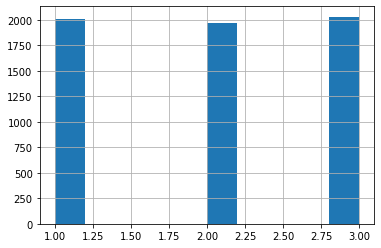

In [143]:
sent_batches_list[-1][0].loc[-6000:, 'action_type'].hist()

In [144]:
sent_batches_list[-1][0].iloc[-6000:, ].info()
sent_batches_list[-1][0].iloc[-6000:, ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dates              6000 non-null   object 
 1   SKU                6000 non-null   object 
 2   user_id            6000 non-null   int64  
 3   price              6000 non-null   float64
 4   year               6000 non-null   UInt32 
 5   week_num           6000 non-null   UInt32 
 6   ret_net_price_min  1744 non-null   float64
 7   action_type        6000 non-null   int64  
dtypes: UInt32(2), float64(2), int64(2), object(2)
memory usage: 386.7+ KB


,dates,SKU,user_id,price,year,week_num,ret_net_price_min,action_type
0,2019-12-01,96588,10794,1089.983877,2019,48,1215.643069,2
1,2019-12-01,68476,32515,1964.184596,2019,48,NaN,3
2,2019-12-01,62526,21329,2788.141906,2019,48,NaN,3
3,2019-12-01,38958,16776,919.273022,2019,48,NaN,2
4,2019-12-01,42934,10651,497.011683,2019,48,NaN,3
...,...,...,...,...,...,...,...,...
5995,2019-12-06,76127,38992,2884.268315,2019,49,NaN,1
5996,2019-12-06,52128,45092,438.050783,2019,49,NaN,2
5997,2019-12-06,21389,28986,1917.996196,2019,49,NaN,1
5998,2019-12-06,74578,11142,1697.530015,2019,49,NaN,1


In [145]:
## prev forecast results + used action_types
prev_batch_results = get_batches2_list[-1][0].iloc[-6000:, ]
prev_batch_sent = sent_batches_list[-1][0].iloc[-6000:, ].drop(columns='price')
prev_batch_sent['dates'] = pd.to_datetime(prev_batch_sent['dates'])
prev_batch_results = prev_batch_results.merge(prev_batch_sent, how='left', on=['SKU', 'dates', 'user_id'])

In [146]:
## update prev_purchases dict
new_purch_prices_df = transactions_df.loc[transactions_df.reset_index()\
    .groupby(['user'])['dates'].idxmax()].sort_values(by = 'dates').reset_index()
new_purch_prices_df.rename(columns={'user': 'user_id'}, inplace=True)
new_purch_prices_df.drop(['index', 'dates', 'SKU'], 1, inplace=True)

for idx, user_id_i in new_purch_prices_df.iterrows():
    prev_purch_dict[user_id_i['user_id']] = user_id_i['price']

In [147]:
# context_columns = ['SKU', 'dates_int', 'price', 'user_id', 'prev_purch',\
#                    'rec', 'freq', 'monet1', 'monet2', 'dates_range']

In [148]:
prev_batch_results.head()

,dates,SKU,user_id,price,bought,year,week_num,ret_net_price_min,action_type
0,2019-12-01,96588,10794,1089.983877,0,2019,48,1215.643069,2
1,2019-12-01,68476,32515,1964.184596,1,2019,48,NaN,3
2,2019-12-01,62526,21329,2788.141906,1,2019,48,NaN,3
3,2019-12-01,38958,16776,919.273022,1,2019,48,NaN,2
4,2019-12-01,42934,10651,497.011683,1,2019,48,NaN,3


In [149]:
%%time
## collect context + action_type + reward data
prev_batch_results[['dates_int', 'prev_purch', 'rec', 'freq', 'monet1', 'monet2', 'dates_range', 'reward']] = 0

for idx, batch_res_i in prev_batch_results.iterrows():
    
    # collect context
    # prev_batch_results.loc[idx, 'dates_int'] = pd.to_datetime(batch_res_i['dates'])
    prev_batch_results.loc[idx, 'dates_int'] = int(time.mktime(batch_res_i['dates'].timetuple()))
    prev_batch_results.loc[idx, 'prev_purch'] = prev_purch_dict[batch_res_i['user_id']]
    prev_batch_results.loc[idx, 'rec'] = bandits_context_dict[batch_res_i.user_id].rec
    prev_batch_results.loc[idx, 'freq'] = bandits_context_dict[batch_res_i.user_id].freq
    prev_batch_results.loc[idx, 'monet1'] = bandits_context_dict[batch_res_i.user_id].monet1
    prev_batch_results.loc[idx, 'monet2'] = bandits_context_dict[batch_res_i.user_id].monet2
    prev_batch_results.loc[idx, 'dates_range'] = bandits_context_dict[batch_res_i.user_id].dates_range
    
    # action_type (already exists)
    
    # reward
#     prev_batch_results.loc[idx, 'reward'] = batch_res_i['price'] * batch_res_i['bought']
    prev_batch_results.loc[idx, 'reward'] = action_dict[batch_res_i['action_type']] * batch_res_i['bought']

    
    bandit_train_df = prev_batch_results[context_columns + ['action_type'] + ['reward']]


CPU times: user 21.9 s, sys: 81.8 ms, total: 22 s
Wall time: 22 s


In [150]:
bandit_train_df.head()

,SKU,dates_int,price,user_id,prev_purch,rec,freq,monet1,monet2,dates_range,action_type,reward
0,96588,1575154800,1089.983877,10794,-1.0,0,2,1,2,385.0,2,0.00
1,68476,1575154800,1964.184596,32515,4065.0,0,2,1,1,665.0,3,0.83
2,62526,1575154800,2788.141906,21329,4227.0,0,0,0,1,613.0,3,0.83
3,38958,1575154800,919.273022,16776,250.0,0,1,0,1,621.0,2,0.88
4,42934,1575154800,497.011683,10651,2489.0,0,0,0,1,621.0,3,0.83


### fit Bandits

In [151]:
bandit_train_df.head()

,SKU,dates_int,price,user_id,prev_purch,rec,freq,monet1,monet2,dates_range,action_type,reward
0,96588,1575154800,1089.983877,10794,-1.0,0,2,1,2,385.0,2,0.00
1,68476,1575154800,1964.184596,32515,4065.0,0,2,1,1,665.0,3,0.83
2,62526,1575154800,2788.141906,21329,4227.0,0,0,0,1,613.0,3,0.83
3,38958,1575154800,919.273022,16776,250.0,0,1,0,1,621.0,2,0.88
4,42934,1575154800,497.011683,10651,2489.0,0,0,0,1,621.0,3,0.83


In [152]:
%%time
# дообучим модель

for index, row in bandit_train_df.iterrows():
    
# for index, row in bandit_train_df.iloc[:1000].iterrows():
#     context = row[context_columns]
#     context = row[context_columns].values.reshape(-1,1)
#     context = row[context_columns].values
    context = row[context_columns].values.astype(float)
    action = int(row['action_type'] - 1)
    reward = row['reward']
    model_2.update(context, action, reward)
    
    if index % 300 == 0:
        print(index)

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
CPU times: user 3min 26s, sys: 2min 11s, total: 5min 37s
Wall time: 43.5 s


### get next batch

In [153]:
%%time

## get new batch
URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))

try:
    print(response.json()['status'])
except:
    pass

# Чтобы перевести полученный ответ в pd.DataFrame
try:
    batch_df = pd.read_json(response.json())
except:
    pass
    
batch_df['dates'] = pd.to_datetime(batch_df['dates'])
# batch_df['price'] = 0
    

CPU times: user 81.8 ms, sys: 7.08 ms, total: 88.9 ms
Wall time: 5.51 s


### get 1st forecast

In [154]:
%%time
## predict prices
column_names = ['dates', 'SKU', 'price', 'year', 'week_num']
predict_prophet_df = pd.DataFrame(columns = column_names)
conf_int = 0.00
ii = 0
sku_list = batch_df.SKU.unique()
prev_action_types = np.zeros(6000)

print(batch_df.head())

for sku_i in sku_list:

    ii += 1
    if ii % 100 == 0:
        print(ii)

    # subset SKU data & init tsCV
    trans_gr_test = batch_df.loc[batch_df.SKU == sku_i, ]
    trans_gr_test = trans_gr_test[['dates', 'SKU']].drop_duplicates()

    # predict
    pred_df1_i = prophet_dict_1[sku_i].predict(trans_gr_test[['dates']]\
                         .rename(columns={'dates':'ds'}))
    pred_df2_i = pd.DataFrame({'SKU': sku_i, 'dates': pred_df1_i.ds,\
                              'price_mean_cl_hat': pred_df1_i.yhat})
#         print(pred_df1_i.yhat.head())

    # join discount & calc price with promo
    pred_df2_i['week_num'] = pred_df2_i['dates'].dt.isocalendar().week
    pred_df2_i['year'] = pred_df2_i['dates'].dt.isocalendar().year
    pred_df3_i = pred_df2_i.merge(promo_df, how='left',\
                     on=['SKU', 'year', 'week_num'])

    pred_df3_i.loc[np.isnan(pred_df3_i.discount), 'discount'] = 0
    pred_df3_i['price'] = pred_df3_i['price_mean_cl_hat'] * \
        (1 - pred_df3_i['discount'])

    # join competitors prices
    pred_df4_i = pred_df3_i.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])
    
#     ## apply action_types for 1st batch
#     pred_df4_i['action_type'] = 0
#     pred_df4_i.loc[(pred_df4_i.price < 2120), 'action_type'] = 1
#     pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'action_type'] = 2
#     pred_df4_i.loc[(pred_df4_i.price > 2515), 'action_type'] = 3
    
#     pred_df4_i.loc[(pred_df4_i.price < 2120), 'price'] = pred_df4_i.loc[(pred_df4_i.price < 2120), 'price'] * 0.95
#     pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'price'] = \
#         pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'price'] * 0.90
#     pred_df4_i.loc[(pred_df4_i.price > 2515), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 2515), 'price'] * 0.85
    
#     # compare competitors prices
#     pred_df4_i['price'] = pred_df4_i[['price', 'ret_net_price_min']].min(axis=1)

    # attach to total df
    predict_prophet_df = predict_prophet_df.\
        append(pred_df4_i[['dates', 'SKU', 'price', 'year',\
                           'week_num']])
#         append(pred_df4_i[['dates', 'SKU', 'price', 'action_type']])

predict_prophet_df_gr = predict_prophet_df.\
    groupby(['dates', 'SKU'], as_index=False).\
    price.agg(np.mean)

batch_df_send = batch_df.merge(predict_prophet_df_gr, how='left',\
                               on=['dates', 'SKU'])

sent_batches_list.append([batch_df_send])
# batch_df_send['dates'] = batch_df_send['dates'].astype(str)

       dates    SKU  user_id
0 2019-12-06  38958    49353
1 2019-12-06  91743    29530
2 2019-12-06  43454    22386
3 2019-12-06  25684    43665
4 2019-12-06  31344    43251
100
200
300
400
500
600
700
800
CPU times: user 3min 8s, sys: 129 ms, total: 3min 8s
Wall time: 3min 8s


In [155]:
predict_prophet_df_gr.head(10)

,dates,SKU,price
0,2019-12-06,10121,2791.157749
1,2019-12-06,10230,1228.875553
2,2019-12-06,10583,3214.575514
3,2019-12-06,11189,3531.041560
4,2019-12-06,11318,4202.478320
5,2019-12-06,11379,3839.359585
6,2019-12-06,11599,4385.076976
7,2019-12-06,11700,2217.525219
8,2019-12-06,12600,994.808847
9,2019-12-06,13110,3636.724198


### get 2nd forecast

In [156]:
# pred_context = full_action_reward.iloc[-2][context_columns].values
# model_2.action(pred_context)
# action_dict = {1: 0.95, 2: 0.9, 3: 0.85}



In [157]:
## prev forecast results + used action_types
new_batch_1st_frcst = sent_batches_list[-1][0].iloc[-6000:, ]

In [158]:
%%time
## collect context + action_type + reward data
new_batch_1st_frcst[['dates_int', 'prev_purch', 'rec', 'freq', 'monet1', 'monet2', 'dates_range']] = 0

for idx, batch_res_i in new_batch_1st_frcst.iterrows():
    
    # collect context
#     new_batch_1st_frcst.loc[idx, 'dates_int'] = batch_res_i.dates.astype(int)
    new_batch_1st_frcst.loc[idx, 'dates_int'] = int(time.mktime(batch_res_i['dates'].timetuple()))
    new_batch_1st_frcst.loc[idx, 'prev_purch'] = prev_purch_dict[batch_res_i['user_id']]
    new_batch_1st_frcst.loc[idx, 'rec'] = bandits_context_dict[batch_res_i.user_id].rec
    new_batch_1st_frcst.loc[idx, 'freq'] = bandits_context_dict[batch_res_i.user_id].freq
    new_batch_1st_frcst.loc[idx, 'monet1'] = bandits_context_dict[batch_res_i.user_id].monet1
    new_batch_1st_frcst.loc[idx, 'monet2'] = bandits_context_dict[batch_res_i.user_id].monet2
    new_batch_1st_frcst.loc[idx, 'dates_range'] = bandits_context_dict[batch_res_i.user_id].dates_range
    
#     # reward
#     prev_batch_results.loc[idx, 'reward'] = batch_res_i.price * batch_res_i.bought

bandit_predict_df = new_batch_1st_frcst[context_columns]
bandit_predict_df['action_type'] = 0

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 14.2 s, sys: 79.5 ms, total: 14.3 s
Wall time: 14.3 s


In [159]:
%%time
for idx, context_raw in bandit_predict_df.iterrows():
#     pred_context = full_action_reward.iloc[-2][context_columns].values
    bandit_predict_df.loc[idx, 'action_type'] = model_2.action(context_raw[context_columns].values) + 1
    bandit_predict_df.loc[idx, 'price'] = bandit_predict_df.loc[idx, 'price'] * \
        action_dict[bandit_predict_df.loc[idx, 'action_type']]

CPU times: user 14.9 s, sys: 9.83 ms, total: 14.9 s
Wall time: 14.9 s


In [160]:
bandit_predict_df.head()

,SKU,dates_int,price,user_id,prev_purch,rec,freq,monet1,monet2,dates_range,action_type
0,38958,1575586800,869.431622,49353,4452.0,0,0,0,0,608.0,3
1,91743,1575586800,2269.372437,29530,-1.0,0,2,1,2,385.0,2
2,43454,1575586800,944.923562,22386,-1.0,0,2,1,2,385.0,3
3,25684,1575586800,1931.879342,43665,-1.0,0,2,1,2,385.0,3
4,31344,1575586800,3928.515454,43251,-1.0,0,2,1,2,385.0,2


In [161]:
batch_df_send = bandit_predict_df

# batch_df_send['dates'] = dt.datetime.fromtimestamp(batch_df_send['dates_int']).astype(str)
batch_df_send['dates'] = pd.to_datetime('2018-01-01')

for idx, batch_row in batch_df_send.iterrows():
    batch_df_send.loc[idx, 'dates'] = dt.datetime.fromtimestamp(batch_row['dates_int'])

batch_df_send['week_num'] = batch_df_send['dates'].dt.isocalendar().week
batch_df_send['year'] = batch_df_send['dates'].dt.isocalendar().year

# join competitors prices
batch_df_send = batch_df_send.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])

# compare competitors prices
batch_df_send['ret_net_price_min'] = batch_df_send['ret_net_price_min'] * 0.99
batch_df_send['price'] = batch_df_send[['price', 'ret_net_price_min']].min(axis=1)

batch_df_send['dates'] = ''
for idx, batch_row in batch_df_send.iterrows():
    batch_df_send.loc[idx, 'dates'] = dt.datetime.fromtimestamp(batch_row['dates_int']).strftime('%Y-%m-%d')

sent_batches_list[-1] = [batch_df_send]
batch_df_send.head()

,SKU,dates_int,price,user_id,prev_purch,rec,freq,monet1,monet2,dates_range,action_type,dates,week_num,year,ret_net_price_min
0,38958,1575586800,869.431622,49353,4452.0,0,0,0,0,608.0,3,2019-12-06,49,2019,NaN
1,91743,1575586800,2269.372437,29530,-1.0,0,2,1,2,385.0,2,2019-12-06,49,2019,NaN
2,43454,1575586800,944.923562,22386,-1.0,0,2,1,2,385.0,3,2019-12-06,49,2019,NaN
3,25684,1575586800,1931.879342,43665,-1.0,0,2,1,2,385.0,3,2019-12-06,49,2019,2285.982823
4,31344,1575586800,3928.515454,43251,-1.0,0,2,1,2,385.0,2,2019-12-06,49,2019,4385.972527


### send batch

In [162]:
## send batch
URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
# df.to_json(orient='records')
req = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                         data=batch_df_send[['dates', 'SKU', 'user_id', 'price']].to_json(orient='records'))
print(req.text)

time.sleep(1)

{"status": "ok"}



### get results (and go to step "get Bandits context, action_type, reward")

In [163]:
## get batch results
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response2 = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))
# Чтобы перевести полученный ответ в pd.DataFrame
batch_df2_get = pd.read_json(response2.json())
batch_df2_get['dates'] = pd.to_datetime(batch_df2_get['dates'])
get_batches2_list.append([batch_df2_get])

time.sleep(1)

### repeat 6.4.7-13 3 more times

Prediction iteration 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 6000 to 11999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dates    6000 non-null   datetime64[ns]
 1   SKU      6000 non-null   int64         
 2   user_id  6000 non-null   int64         
 3   price    6000 non-null   float64       
 4   bought   6000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 234.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SKU                6000 non-null   int64  
 1   dates_int          6000 non-null   int64  
 2   price              6000 non-null   float64
 3   user_id            6000 non-null   int64  
 4   prev_purch         6000 non-null   float64
 5   rec                6000 non-null 

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{"status": "ok"}

Prediction iteration 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 12000 to 17999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dates    6000 non-null   datetime64[ns]
 1   SKU      6000 non-null   int64         
 2   user_id  6000 non-null   int64         
 3   price    6000 non-null   float64       
 4   bought   6000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 234.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SKU                6000 non-null   int64  
 1   dates_int          6000 non-null   int64  
 2   price              6000 non-null   float64
 3   user_id            6000 non-null   int64  
 4   prev_purch         6000 non-null   float64
 5   rec           

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{"status": "ok"}

Prediction iteration 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 18000 to 23999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dates    6000 non-null   datetime64[ns]
 1   SKU      6000 non-null   int64         
 2   user_id  6000 non-null   int64         
 3   price    6000 non-null   float64       
 4   bought   6000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 234.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SKU                6000 non-null   int64  
 1   dates_int          6000 non-null   int64  
 2   price              6000 non-null   float64
 3   user_id            6000 non-null   int64  
 4   prev_purch         6000 non-null   float64
 5   rec           

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{"status": "ok"}

CPU times: user 55min 16s, sys: 25min 1s, total: 1h 20min 17s
Wall time: 21min 44s


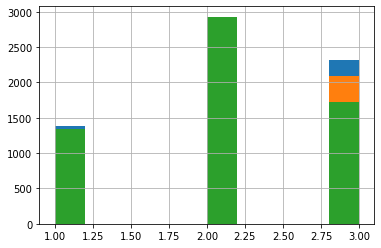

In [164]:
%%time
for iter_i in range(3):
    
    print('Prediction iteration', iter_i)

    ### get Bandits context, action_type, reward

    get_batches2_list[-1][0].iloc[-6000:, ].info()
    get_batches2_list[-1][0].iloc[-6000:, ]

    sent_batches_list[-1][0].loc[-6000:, 'action_type'].hist()

    sent_batches_list[-1][0].iloc[-6000:, ].info()
    sent_batches_list[-1][0].iloc[-6000:, ]

    ## prev forecast results + used action_types
    prev_batch_results = get_batches2_list[-1][0].iloc[-6000:, ]
    prev_batch_sent = sent_batches_list[-1][0].iloc[-6000:, ].drop(columns='price')
    prev_batch_sent['dates'] = pd.to_datetime(prev_batch_sent['dates'])
    prev_batch_results = prev_batch_results.merge(prev_batch_sent, how='left', on=['SKU', 'dates', 'user_id'])

    ## update prev_purchases dict
    new_purch_prices_df = transactions_df.loc[transactions_df.reset_index()\
        .groupby(['user'])['dates'].idxmax()].sort_values(by = 'dates').reset_index()
    new_purch_prices_df.rename(columns={'user': 'user_id'}, inplace=True)
    new_purch_prices_df.drop(['index', 'dates', 'SKU'], 1, inplace=True)

    for idx, user_id_i in new_purch_prices_df.iterrows():
        prev_purch_dict[user_id_i['user_id']] = user_id_i['price']

    # context_columns = ['SKU', 'dates_int', 'price', 'user_id', 'prev_purch',\
    #                    'rec', 'freq', 'monet1', 'monet2', 'dates_range']

    prev_batch_results.head()

    
    ## collect context + action_type + reward data
    prev_batch_results[['dates_int', 'prev_purch', 'rec', 'freq', 'monet1', 'monet2', 'dates_range', 'reward']] = 0

    for idx, batch_res_i in prev_batch_results.iterrows():

        # collect context
        # prev_batch_results.loc[idx, 'dates_int'] = pd.to_datetime(batch_res_i['dates'])
        prev_batch_results.loc[idx, 'dates_int'] = int(time.mktime(batch_res_i['dates'].timetuple()))
        prev_batch_results.loc[idx, 'prev_purch'] = prev_purch_dict[batch_res_i['user_id']]
        prev_batch_results.loc[idx, 'rec'] = bandits_context_dict[batch_res_i.user_id].rec
        prev_batch_results.loc[idx, 'freq'] = bandits_context_dict[batch_res_i.user_id].freq
        prev_batch_results.loc[idx, 'monet1'] = bandits_context_dict[batch_res_i.user_id].monet1
        prev_batch_results.loc[idx, 'monet2'] = bandits_context_dict[batch_res_i.user_id].monet2
        prev_batch_results.loc[idx, 'dates_range'] = bandits_context_dict[batch_res_i.user_id].dates_range

        # action_type (already exists)

        # reward
    #     prev_batch_results.loc[idx, 'reward'] = batch_res_i['price'] * batch_res_i['bought']
        prev_batch_results.loc[idx, 'reward'] = action_dict[batch_res_i['action_type']] * batch_res_i['bought']


        bandit_train_df = prev_batch_results[context_columns + ['action_type'] + ['reward']]

    bandit_train_df.head()

    
    ### fit Bandits

    bandit_train_df.head()

    
    # дообучим модель

    for index, row in bandit_train_df.iterrows():

    # for index, row in bandit_train_df.iloc[:1000].iterrows():
    #     context = row[context_columns]
    #     context = row[context_columns].values.reshape(-1,1)
    #     context = row[context_columns].values
        context = row[context_columns].values.astype(float)
        action = int(row['action_type'] - 1)
        reward = row['reward']
        model_2.update(context, action, reward)

        if index % 300 == 0:
            print(index)

    
    ### get next batch

    

    ## get new batch
    URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
    response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))

    try:
        print(response.json()['status'])
    except:
        pass

    # Чтобы перевести полученный ответ в pd.DataFrame
    try:
        batch_df = pd.read_json(response.json())
    except:
        pass

    batch_df['dates'] = pd.to_datetime(batch_df['dates'])
    # batch_df['price'] = 0


    ### get 1st forecast

    
    ## predict prices
    column_names = ['dates', 'SKU', 'price', 'year', 'week_num']
    predict_prophet_df = pd.DataFrame(columns = column_names)
    conf_int = 0.00
    ii = 0
    sku_list = batch_df.SKU.unique()
    prev_action_types = np.zeros(6000)

    print(batch_df.head())

    for sku_i in sku_list:

        ii += 1
        if ii % 100 == 0:
            print(ii)

        # subset SKU data & init tsCV
        trans_gr_test = batch_df.loc[batch_df.SKU == sku_i, ]
        trans_gr_test = trans_gr_test[['dates', 'SKU']].drop_duplicates()

        # predict
        pred_df1_i = prophet_dict_1[sku_i].predict(trans_gr_test[['dates']]\
                             .rename(columns={'dates':'ds'}))
        pred_df2_i = pd.DataFrame({'SKU': sku_i, 'dates': pred_df1_i.ds,\
                                  'price_mean_cl_hat': pred_df1_i.yhat})
    #         print(pred_df1_i.yhat.head())

        # join discount & calc price with promo
        pred_df2_i['week_num'] = pred_df2_i['dates'].dt.isocalendar().week
        pred_df2_i['year'] = pred_df2_i['dates'].dt.isocalendar().year
        pred_df3_i = pred_df2_i.merge(promo_df, how='left',\
                         on=['SKU', 'year', 'week_num'])

        pred_df3_i.loc[np.isnan(pred_df3_i.discount), 'discount'] = 0
        pred_df3_i['price'] = pred_df3_i['price_mean_cl_hat'] * \
            (1 - pred_df3_i['discount'])

        # join competitors prices
        pred_df4_i = pred_df3_i.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])

    #     ## apply action_types for 1st batch
    #     pred_df4_i['action_type'] = 0
    #     pred_df4_i.loc[(pred_df4_i.price < 2120), 'action_type'] = 1
    #     pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'action_type'] = 2
    #     pred_df4_i.loc[(pred_df4_i.price > 2515), 'action_type'] = 3

    #     pred_df4_i.loc[(pred_df4_i.price < 2120), 'price'] = pred_df4_i.loc[(pred_df4_i.price < 2120), 'price'] * 0.95
    #     pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'price'] = \
    #         pred_df4_i.loc[((pred_df4_i.price >= 2120) & (pred_df4_i.price <= 2515)), 'price'] * 0.90
    #     pred_df4_i.loc[(pred_df4_i.price > 2515), 'price'] = pred_df4_i.loc[(pred_df4_i.price > 2515), 'price'] * 0.85

        # compare competitors prices
        pred_df4_i['price'] = pred_df4_i[['price', 'ret_net_price_min']].min(axis=1)

        # attach to total df
        predict_prophet_df = predict_prophet_df.\
            append(pred_df4_i[['dates', 'SKU', 'price', 'year', 'week_num']])
    #         append(pred_df4_i[['dates', 'SKU', 'price', 'action_type']])

    predict_prophet_df_gr = predict_prophet_df.\
        groupby(['dates', 'SKU'], as_index=False).\
        price.agg(np.mean)

    batch_df_send = batch_df.merge(predict_prophet_df_gr, how='left',\
                                   on=['dates', 'SKU'])

    sent_batches_list.append([batch_df_send])
    # batch_df_send['dates'] = batch_df_send['dates'].astype(str)

    ### get 2nd forecast

    # pred_context = full_action_reward.iloc[-2][context_columns].values
    # model_2.action(pred_context)
    # action_dict = {1: 0.95, 2: 0.9, 3: 0.85}



    ## prev forecast results + used action_types
    new_batch_1st_frcst = sent_batches_list[-1][0].iloc[-6000:, ]

    
    ## collect context + action_type + reward data
    new_batch_1st_frcst[['dates_int', 'prev_purch', 'rec', 'freq', 'monet1', 'monet2', 'dates_range']] = 0

    for idx, batch_res_i in new_batch_1st_frcst.iterrows():

        # collect context
    #     new_batch_1st_frcst.loc[idx, 'dates_int'] = batch_res_i.dates.astype(int)
        new_batch_1st_frcst.loc[idx, 'dates_int'] = int(time.mktime(batch_res_i['dates'].timetuple()))
        new_batch_1st_frcst.loc[idx, 'prev_purch'] = prev_purch_dict[batch_res_i['user_id']]
        new_batch_1st_frcst.loc[idx, 'rec'] = bandits_context_dict[batch_res_i.user_id].rec
        new_batch_1st_frcst.loc[idx, 'freq'] = bandits_context_dict[batch_res_i.user_id].freq
        new_batch_1st_frcst.loc[idx, 'monet1'] = bandits_context_dict[batch_res_i.user_id].monet1
        new_batch_1st_frcst.loc[idx, 'monet2'] = bandits_context_dict[batch_res_i.user_id].monet2
        new_batch_1st_frcst.loc[idx, 'dates_range'] = bandits_context_dict[batch_res_i.user_id].dates_range

    #     # reward
    #     prev_batch_results.loc[idx, 'reward'] = batch_res_i.price * batch_res_i.bought

    bandit_predict_df = new_batch_1st_frcst[context_columns]
    bandit_predict_df['action_type'] = 0

    
    for idx, context_raw in bandit_predict_df.iterrows():
    #     pred_context = full_action_reward.iloc[-2][context_columns].values
        bandit_predict_df.loc[idx, 'action_type'] = model_2.action(context_raw[context_columns].values) + 1
        bandit_predict_df.loc[idx, 'price'] = bandit_predict_df.loc[idx, 'price'] * \
            action_dict[bandit_predict_df.loc[idx, 'action_type']]

    bandit_predict_df.head()

    batch_df_send = bandit_predict_df
    # batch_df_send['dates'] = dt.datetime.fromtimestamp(batch_df_send['dates_int']).astype(str)
    
#     batch_df_send['dates'] = ''
#     for idx, batch_row in batch_df_send.iterrows():
#         batch_df_send.loc[idx, 'dates'] = dt.datetime.fromtimestamp(batch_row['dates_int']).strftime('%Y-%m-%d')
    
    batch_df_send['dates'] = pd.to_datetime('2018-01-01')

    ## compare with competitors
    for idx, batch_row in batch_df_send.iterrows():
        batch_df_send.loc[idx, 'dates'] = dt.datetime.fromtimestamp(batch_row['dates_int'])

    batch_df_send['week_num'] = batch_df_send['dates'].dt.isocalendar().week
    batch_df_send['year'] = batch_df_send['dates'].dt.isocalendar().year

    # join competitors prices
    batch_df_send = batch_df_send.merge(canc_df_gr, how='left', on=['year', 'week_num', 'SKU'])

    # compare competitors prices
    batch_df_send['ret_net_price_min'] = batch_df_send['ret_net_price_min'] * 0.99
    batch_df_send['price'] = batch_df_send[['price', 'ret_net_price_min']].min(axis=1)

    batch_df_send['dates'] = ''
    for idx, batch_row in batch_df_send.iterrows():
        batch_df_send.loc[idx, 'dates'] = dt.datetime.fromtimestamp(batch_row['dates_int']).strftime('%Y-%m-%d')

    
    batch_df_send.head()
    sent_batches_list[-1] = [batch_df_send]



    ### send batch

    ## send batch
    URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
    # df.to_json(orient='records')
    req = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                             data=batch_df_send[['dates', 'SKU', 'user_id', 'price']].to_json(orient='records'))
    print(req.text)

    time.sleep(1)

    ### get results (and go to step "get Bandits context, action_type, reward")

    ## get batch results
    URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
    response2 = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))
    # Чтобы перевести полученный ответ в pd.DataFrame
    batch_df2_get = pd.read_json(response2.json())
    batch_df2_get['dates'] = pd.to_datetime(batch_df2_get['dates'])
    get_batches2_list.append([batch_df2_get])

    time.sleep(1)